In [18]:
import json
import snowflake.connector
from sqlalchemy.dialects import registry
registry.register('snowflake', 'snowflake.sqlalchemy', 'dialect')  # Register the Snowflake dialect
from sqlalchemy import create_engine

from pathlib import Path
from joblib import dump, load
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import sklearn
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report, recall_score, confusion_matrix, roc_auc_score, precision_score, f1_score, roc_curve, auc

from catboost import CatBoostClassifier, Pool

import gzip
import shutil
import os
import tempfile

import shap

import warnings
warnings.filterwarnings('ignore')

In [9]:
# Saved model path
model_directory = Path.cwd() / 'model'
model_path = list(model_directory.glob(pattern="*.gz"))[0]

In [10]:
def load_model():
    # Decompress the model file into memory
    with gzip.open(model_path, "rb") as f:
        uncompressed_data = f.read()

    # Write the decompressed data to a temporary file
    with tempfile.NamedTemporaryFile(delete=False) as tmp_file:
        tmp_file.write(uncompressed_data)
        tmp_file_path = tmp_file.name

    # Load the model from the temporary file
    model = CatBoostClassifier()
    model.load_model(tmp_file_path)

    # Clean up the temporary file
    os.remove(tmp_file_path)

    return model

In [11]:
# Load the pre-trained CatBoost model
cat_model = load_model()

In [19]:
# Path to train, validation and test datasets
path_processed_data = Path.cwd().parent / 'clean_data'

In [16]:
X_train_path = path_processed_data / 'X_train.pkl'
y_train_path = path_processed_data / 'y_train.pkl'

X_val_path = path_processed_data / 'X_val.pkl'
y_val_path = path_processed_data / 'y_val.pkl'

In [17]:
# Load the datasets
X_train = load(X_train_path)
y_train = load(y_train_path)
X_val = load(X_val_path)
y_val = load(y_val_path)

## SHAP plots

SHAP (SHapley Additive exPlanations) by Lundberg and Lee (2017) is a method to explain individual predictions. 

The goal of SHAP is to explain the prediction of an instance x by computing the contribution of each feature to the prediction. The SHAP explanation method computes Shapley values from coalitional game theory. The feature values of a data instance act as players in a coalition. Shapley values tell us how to fairly distribute the “payout” (= the prediction) among the features. A player can be an individual feature value, e.g. for tabular data. 

The interpretation of the Shapley value is: Given the current set of feature values, the contribution of a feature value to the difference between the actual prediction and the mean prediction is the estimated Shapley value. <br>

The Shapley value returns a simple value per feature, but no prediction model like LIME. This means it cannot be used to make statements about changes in prediction for changes in the input, such as: “If I were to earn €300 more a year, my credit score would increase by 5 points.”

In [20]:
explainercat = shap.TreeExplainer(cat_model)
shap_values_cat_train = explainercat.shap_values(X_train)
shap_values_cat_test = explainercat.shap_values(X_val)

In [21]:
nr_of_features = X_val.shape[1]
nr_of_features

56

### SHAP feature importance

The idea behind SHAP feature importance is simple: <br>
* Features with large absolute Shapley values are important. <br>
* Since we want the global importance, we **average** the **absolute** Shapley values per feature across the data.

#### Differences in Feature Importance - CatBoost vs SHAP values
The differences in feature importance rankings between CatBoost's built-in feature importance and SHAP values occur because they use different methodologies to measure "importance."

**Why the Rankings Differ**
1. *CatBoost Feature Importance*:
    * Measures how much each feature contributes to reducing `loss/error` in the model during training.
    * Focuses on the `split-level importance`: Features that split the data and result in the greatest reduction in model error are deemed more important.
    * It's fast and directly derived from the way the model is built but does not explain how features influence specific predictions.
2. *SHAP (SHapley Additive exPlanations)*:
    * Measures the `average impact` of each feature on the model's predictions across all data points.
    * Considers how each feature changes the model's output for individual data points, using a game-theory approach to fairly allocate "credit" for a prediction.
    * Focuses on `global explainability`, providing both an overview of feature importance and detailed insights into individual predictions.
    * SHAP is more robust for understanding `real-world influence` on predictions but is computationally heavier.


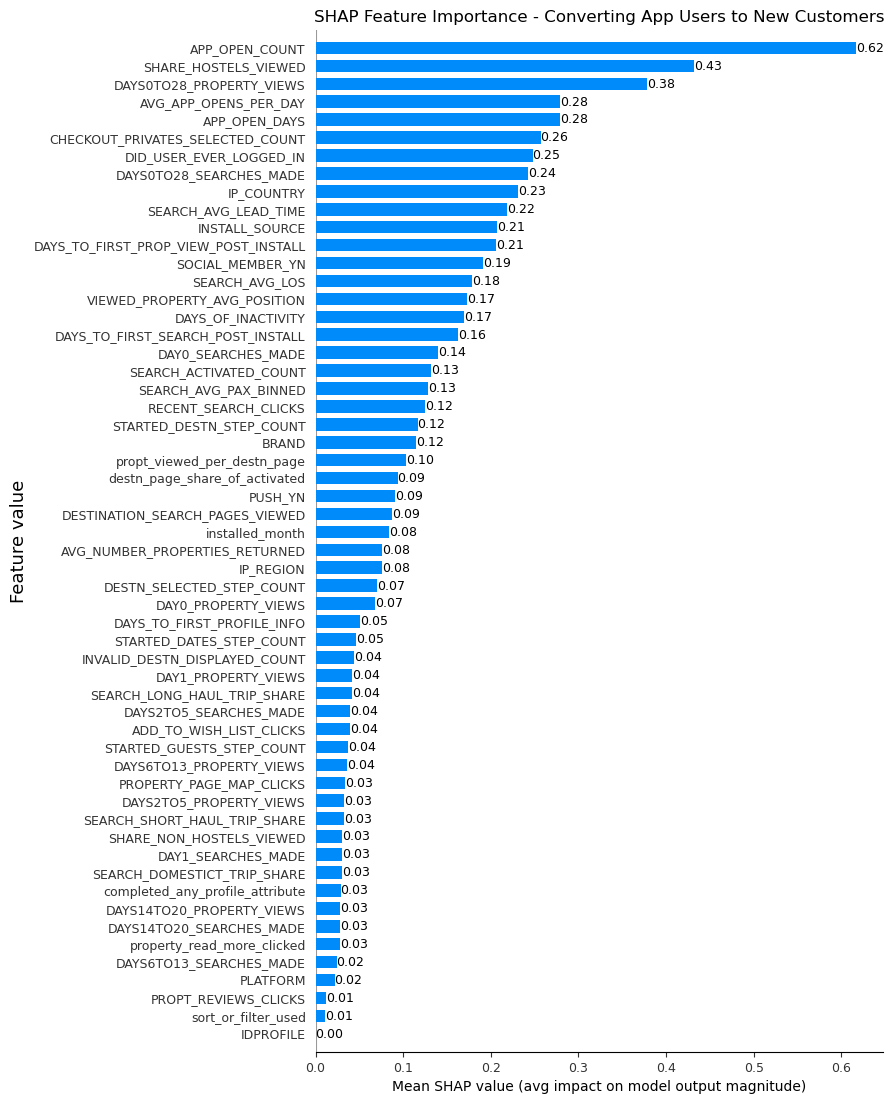

In [33]:
# Generate the plot but do not show it immediately (show=False)
shap.summary_plot(
    shap_values_cat_test, 
    X_val, 
    plot_type="bar",
    plot_size=(10, 11),
    max_display=nr_of_features,
    show=False,
)

# Get the current figure and axes objects
fig, ax = plt.gcf(), plt.gca()

# Modifying main plot parameters
ax.tick_params(labelsize=14)
ax.set_xlabel("Mean SHAP value (avg impact on model output magnitude)", fontsize=10)
ax.set_title('SHAP Feature Importance - Converting App Users to New Customers', fontsize=12)

# Annotating the bars with SHAP values
bars = ax.patches  # Get the list of bar containers
for bar in bars:
    value = bar.get_width()  # Get the width of the bar (the SHAP value)
    y = bar.get_y() + bar.get_height() / 2  # Get the y position to place the text
    ax.text(value, y, f'{value:.2f}', va='center', ha='left', fontsize=9)

# Get colorbar
cb_ax = fig.axes[0] 

# Modifying color bar parameters
cb_ax.tick_params(labelsize=9)
cb_ax.set_ylabel("Feature value", fontsize=13)

# Show the plot
plt.show()

No surprise that 'the number of times the app was opened' came in on the first position. 
However, it's interesting to see that viewing the 'reviews' of a property is on the 3rd position.

### SHAP summary plot - Feature value impact

The summary plot combines feature importance with feature effects: 
* Each point on the summary plot is a Shapley value for a feature and an instance. 
* The position on the y-axis is determined by the feature and on the x-axis by the Shapley value. 
* The color represents the value of the feature from low to high. 
* Overlapping points are jittered in y-axis direction, so we get a sense of the distribution of the Shapley values per feature. 
* The features are ordered according to their importance.

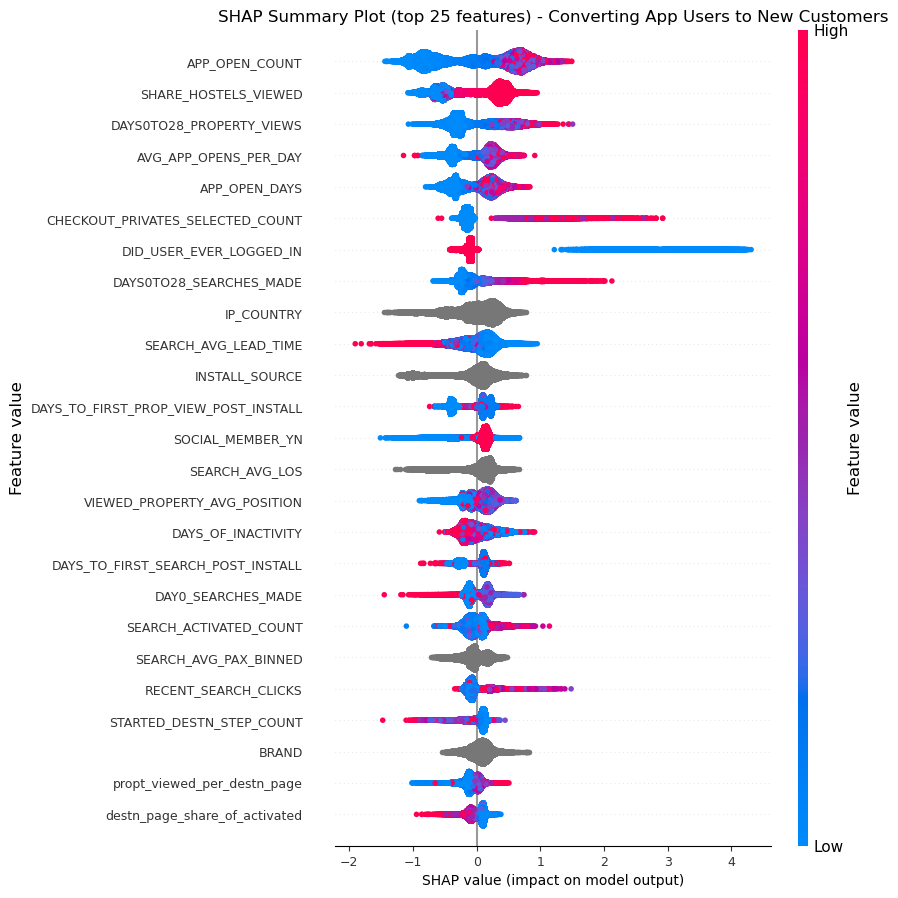

In [35]:
display_n_features = min(nr_of_features, 25)

shap.summary_plot(
                shap_values_cat_test, 
                X_val, 
                plot_type="dot",
                plot_size=(10,9),
                max_display=min(display_n_features, 25),
                show=False,
                )

# Get the current figure and axes objects
fig, ax = plt.gcf(), plt.gca()

# Modifying main plot parameters
ax.tick_params(labelsize=14)
ax.set_xlabel("SHAP value (impact on model output)", fontsize=10)
ax.set_title(f"SHAP Summary Plot (top {display_n_features} features) - Converting App Users to New Customers", fontsize=12)

# Get colorbar
cb_ax = fig.axes[0] 

# Modifying color bar parameters
cb_ax.tick_params(labelsize=9)
cb_ax.set_ylabel("Feature value", fontsize=12)

plt.show()